In [1]:
from algorithms.root_to_liveql import root_to_liveql
from eflint.eflint_lib import EF
from eflint.eflint_parser import get_node_to_type_map, create_graph, get_parameter_facts
from graph_visualizer import visualize_graph

In [2]:
ef = EF()
ef.revert(1)
ef.phrase("Fact entity Identified by String")
ef.phrase("Fact number_of_legs Identified by entity * int")
ef.phrase("Fact featherless Identified by entity")
ef.phrase("Fact biped Identified by entity Holds when (Exists number_of_legs : number_of_legs(entity, 2))")
ef.phrase("Fact intelligent Identified by entity")
ef.phrase("Fact human Identified by entity Holds when (biped(entity) && featherless(entity)) || intelligent(entity)")

{'all-disabled-transitions': [],
 'all-duties': [],
 'all-enabled-transitions': [],
 'created_facts': [],
 'errors': [],
 'inst-query-results': [],
 'new-disabled-transitions': [],
 'new-duties': [],
 'new-enabled-transitions': [],
 'new-state': 7,
 'old-state': 6,
 'output-events': [],
 'query-results': [],
 'response': 'success',
 'source_contents': [],
 'target_contents': [],
 'terminated-duties': [],
 'terminated_facts': [],
 'violations': []}

In [3]:
ef.facts()

{'values': []}

In [4]:
type_res = ef.types()
fact_res = ef.facts()
node_name_to_node = create_graph(type_res)
node_to_type_map = get_node_to_type_map(type_res)
parameter_facts = get_parameter_facts(type_res, fact_res)

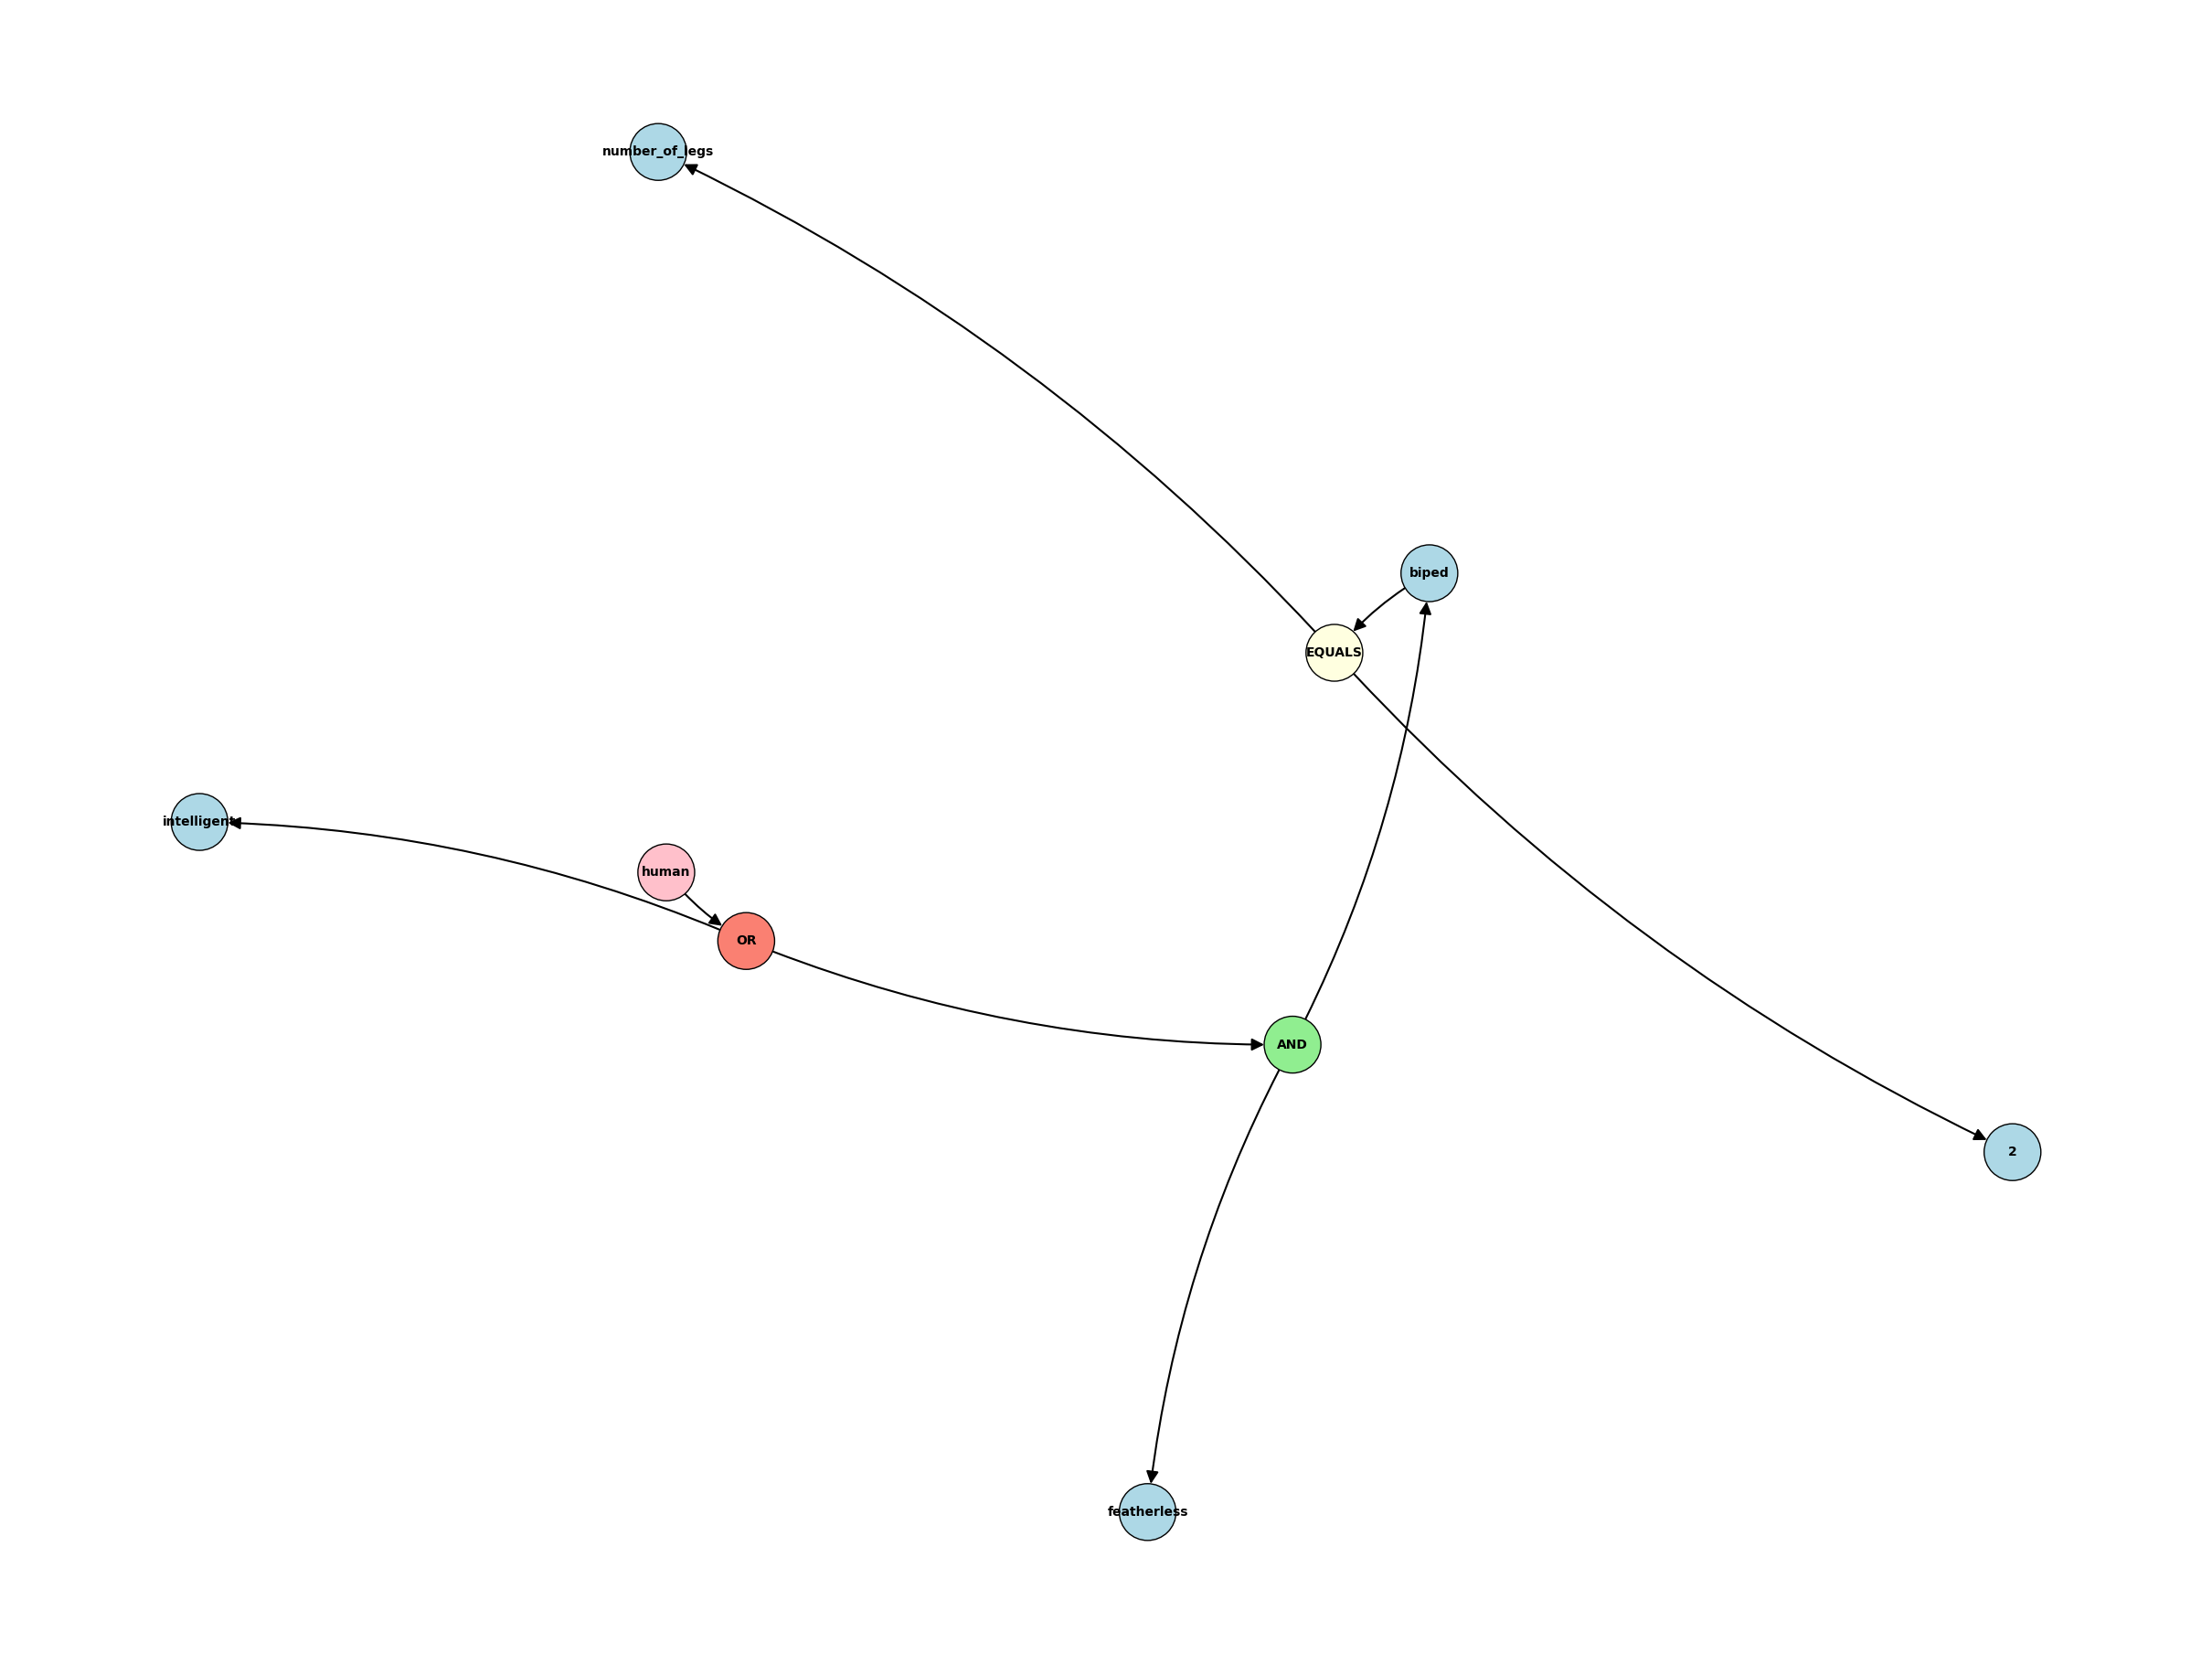

<module 'matplotlib.pyplot' from '/Users/tiemfah/Projects/eFLINTAnswers/.venv/lib/python3.13/site-packages/matplotlib/pyplot.py'>

In [5]:
visualize_graph(node_name_to_node["human"])

In [19]:
human_node = node_name_to_node["human"]
dsl_content = root_to_liveql(human_node, node_to_type_map, parameter_facts)

In [20]:
print(dsl_content)

form humanForm {

	"Is the actor intelligent?" intelligent: bool
	"Is the actor not intelligent?" not_intelligent: bool
	if (intelligent) {
		"Property human holds" result: bool(true)
	}
	if (not_intelligent) {
		"Is the actor featherless?" featherless: bool
		"Is the actor not featherless?" not_featherless: bool
		"How many number of legs does the actor have?" number_of_legs: int
		if (number_of_legs == 2 && featherless) {
			"Property human holds" result: bool(true)
		}
		if ((number_of_legs != 2 || not_featherless) && not_intelligent) {
			"Property human does not holds" result: bool(true)
		}
	}
}


In [21]:
# save_dsl_to_file(dsl_content, "human", "/Users/tiemfah/Projects/LiveQL/bin/nl/cwi/swat/liveql/examples/eflint.ql")
# open_liveql()

DSL saved to /Users/tiemfah/Projects/LiveQL/bin/nl/cwi/swat/liveql/examples/eflint.ql
+(0, answerable("Is the actor intelligent?", intelligent, boolean))
+(0, answerable("Is the actor not intelligent?", not_intelligent, boolean))
+(0, ifThen(intelligent, [computed("Property human holds", result, boolean)]))
+(0, ifThen(not_intelligent, [answerable("Is the actor featherless?", featherless, boolean); answerable("Is the actor not featherless?", not_featherless, boolean); answerable("Is the actor not featherless?", not_featherless, boolean); answerable("Is the actor not featherless?", not_featherless, boolean); answerable("Is the actor not featherless?", not_featherless, boolean)]))


In [61]:
import matplotlib.pyplot as plt
import networkx as nx

from model import *


def visualize_graph_test(node: ALL_NODE_TYPES, fig_size=(24, 18), title=None):
    """
    Visualize a Node and its dependencies as a network graph using NetworkX and Matplotlib.
    Properly handles AndNode and OrNode types.
    """
    # Create directed graph
    graph = nx.DiGraph()

    # Keep track of visited nodes to avoid cycles
    visited = set()

    root_node = node

    # Add nodes and edges recursively
    def add_nodes_and_edges(n, parent=None):
        if isinstance(n, EqualsNode):
            node_label = "EQUALS"
            node_color = 'lightyellow'
        elif isinstance(n, LesserNode):
            node_label = "LESSER"
            node_color = 'lightyellow'
        elif isinstance(n, LesserOrEqualNode):
            node_label = "LESSER_OR_EQUAL"
            node_color = 'lightyellow'
        elif isinstance(n, GreaterNode):
            node_label = "GREATER"
            node_color = 'lightyellow'
        elif isinstance(n, GreaterOrEqualNode):
            node_label = "GREATER_OR_EQUAL"
            node_color = 'lightyellow'
        elif isinstance(n, AndNode):
            node_label = "AND"
            node_color = 'lightgreen'
        elif isinstance(n, OrNode):
            node_label = "OR"
            node_color = 'salmon'
        elif isinstance(n, NotNode):
            node_label = "NOT"
            node_color = '#C65769'
        elif isinstance(n, Node):
            node_label = n.name
            node_color = 'lightblue'
            if id(n) == id(root_node):
                node_color = 'pink'
        else:
            raise ValueError(f"Unknown node type {type(n)}, {n}")

        # Add the node with its attributes
        graph.add_node(id(n), label=node_label, color=node_color)

        # Add edge from parent if it exists
        if parent:
            graph.add_edge(parent, id(n))

        # Skip if we've already processed this Node to avoid cycles
        if isinstance(n, Node) and n.name in visited:
            return

        # Mark as visited
        if isinstance(n, Node):
            visited.add(id(n))

        # Process dependencies
        for dep in n.dependencies:
            if dep.name != "intelligent":
                add_nodes_and_edges(dep, id(n))

        if isinstance(n, EqualsNode):
            add_nodes_and_edges(n.left, id(n))
            add_nodes_and_edges(n.right, id(n))

    # Start with the main node
    add_nodes_and_edges(node)

    # Extract node attributes
    node_colors = [graph.nodes[n].get('color', 'white') for n in graph.nodes()]
    node_labels = {n: graph.nodes[n].get('label', n) for n in graph.nodes()}

    # Create figure
    plt.figure(figsize=fig_size)
    if title:
        plt.title(title)

    # Set node positions
    pos = nx.spring_layout(graph, seed=42, k=4.0, iterations=500)

    # Draw nodes
    nx.draw(graph, pos,
            labels=node_labels,
            node_color=node_colors,
            edgecolors='black',
            node_size=20000,
            font_size=20,
            font_weight='bold',
            width=1.5,
            arrows=True,
            arrowsize=50,
            arrowstyle='-|>',
            connectionstyle='arc3,rad=0.1')

    # Adjust figure margins instead of using tight_layout
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    plt.axis('off')
    plt.show()
    return plt


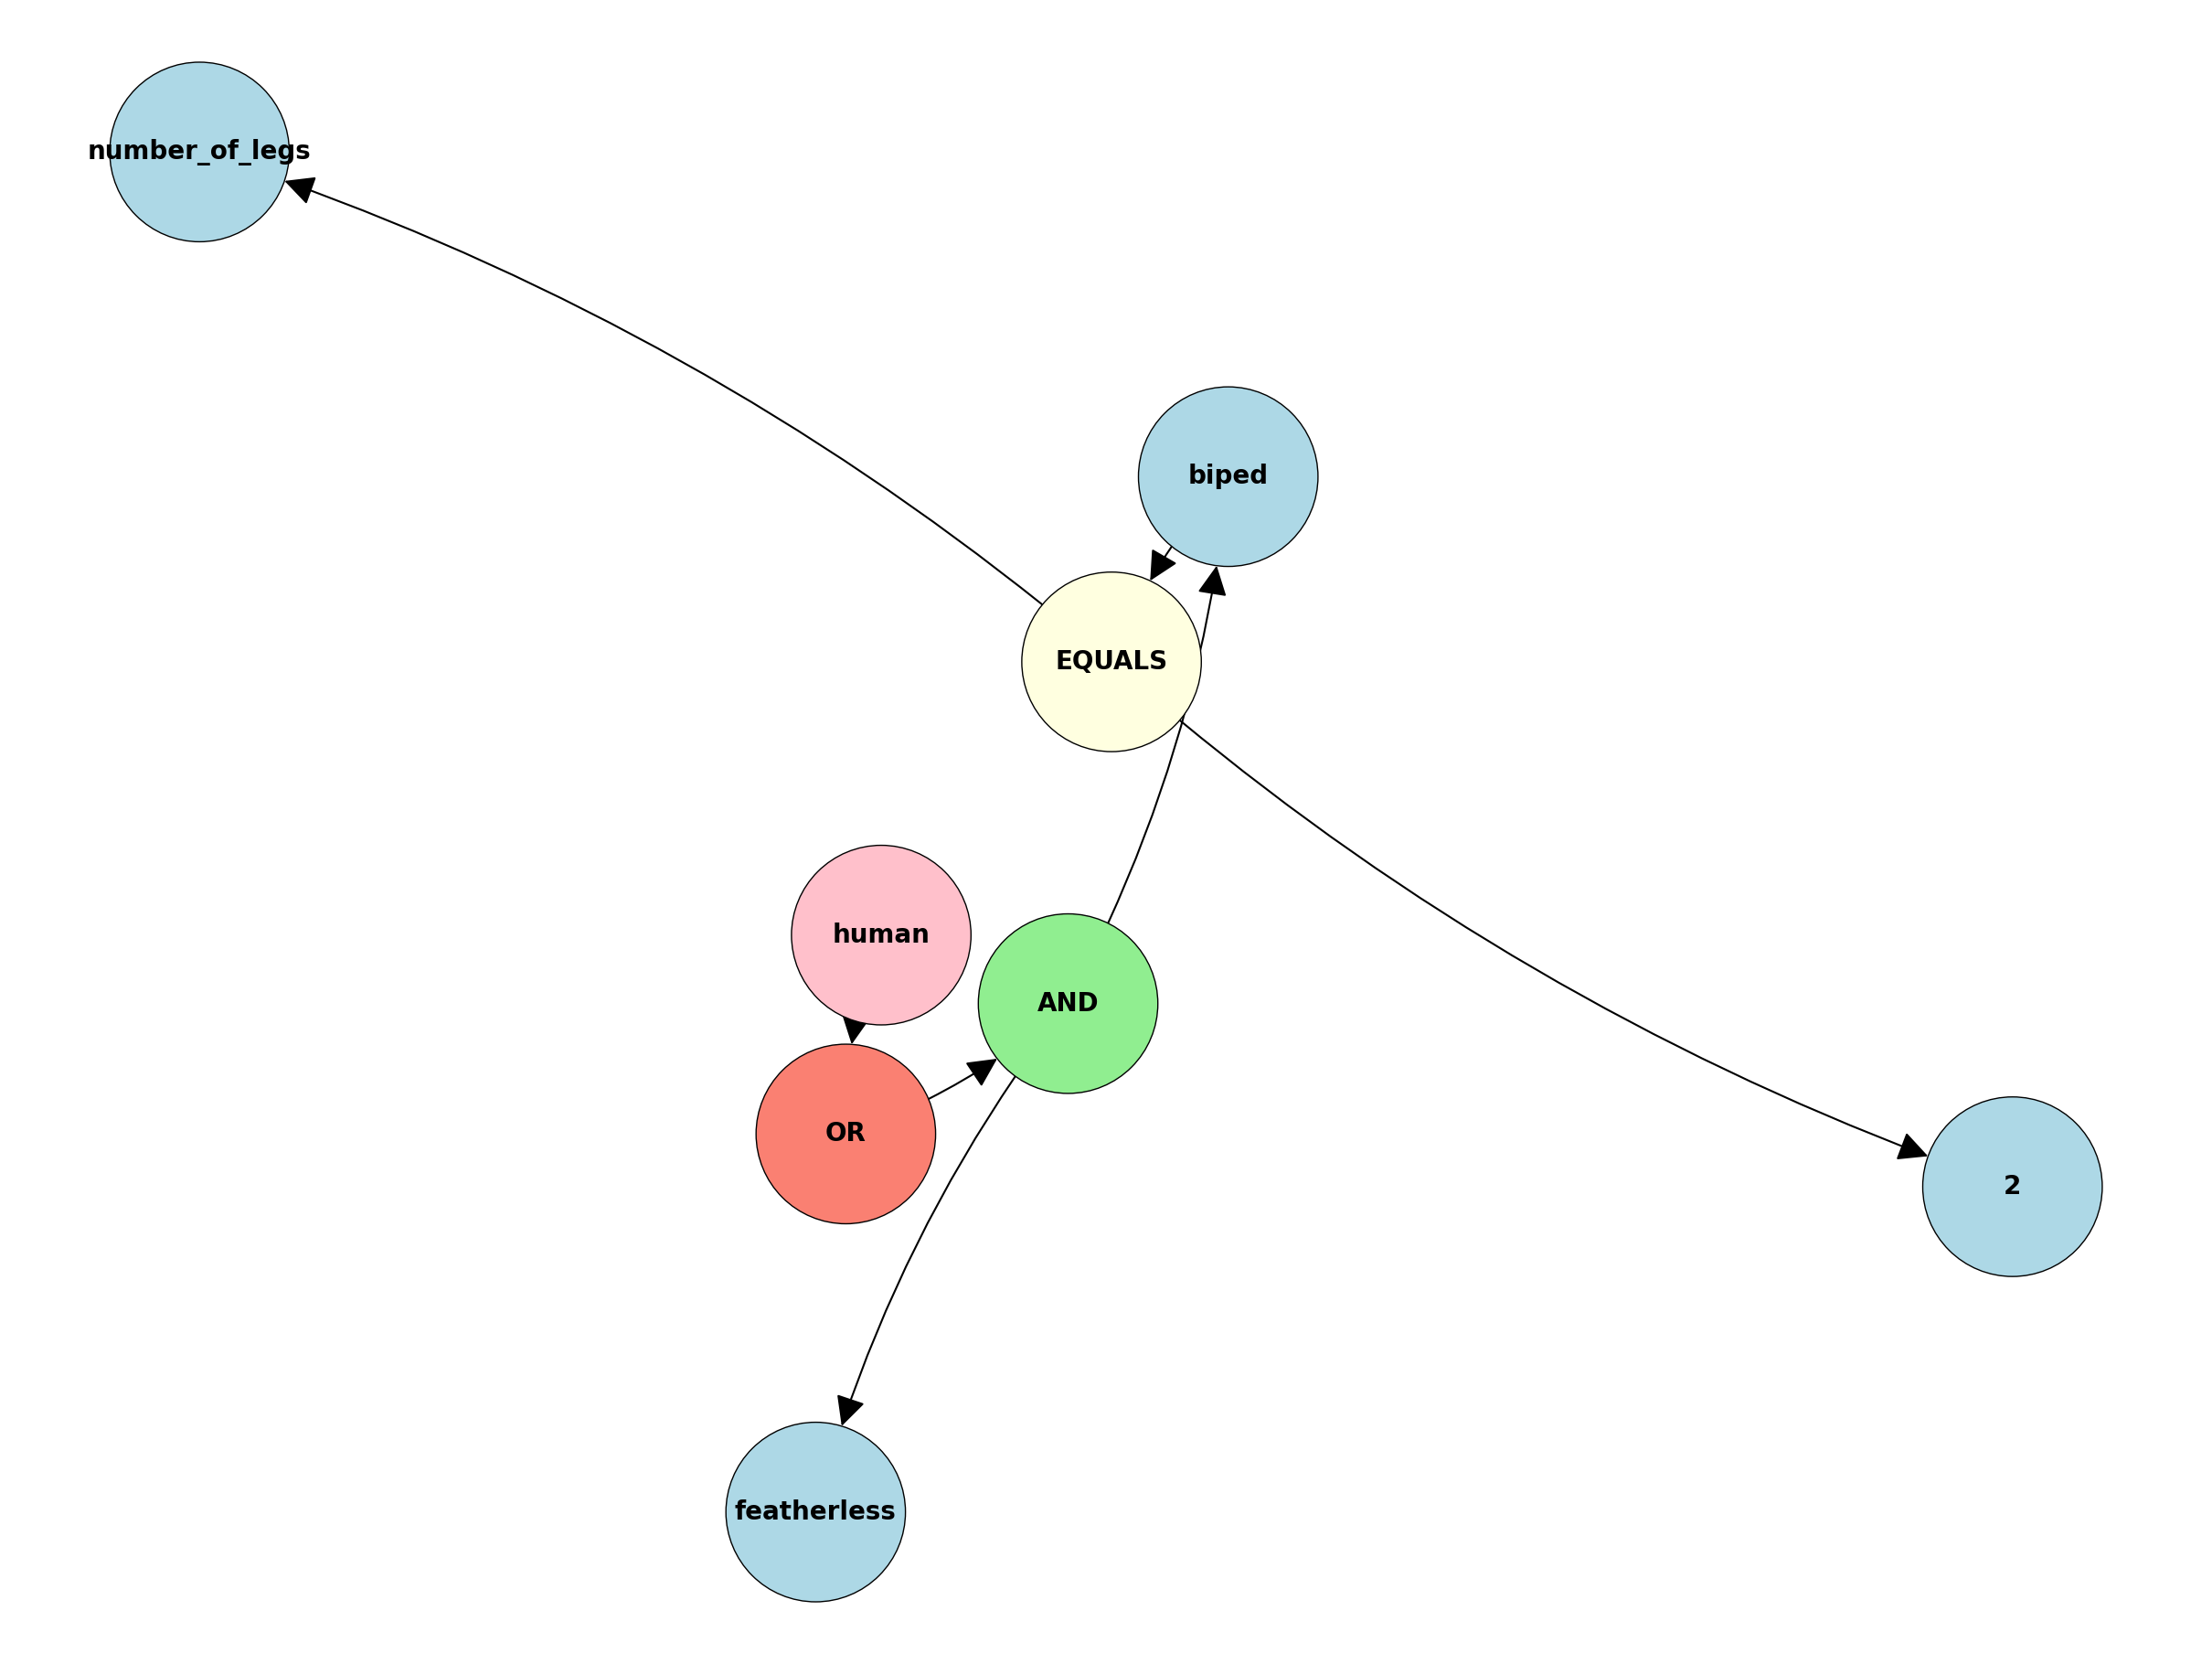

<module 'matplotlib.pyplot' from '/Users/tiemfah/Projects/eFLINTAnswers/.venv/lib/python3.13/site-packages/matplotlib/pyplot.py'>

In [62]:
visualize_graph_test(node_name_to_node["human"])